In [8]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [9]:
import numpy as np
import pandas as pd


In [10]:
import datetime as dt


## Reflecting Tables into SQLAlchemy ORM

In [11]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [12]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [16]:
# Query All Records in the the Database
#data = engine.execute("SELECT * FROM hawaii")

#for record in data:
 #   print(record)

In [17]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [25]:
# To view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [26]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [27]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Exploratory Climate Analysis (for 1 year)

In [36]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
max_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()



In [39]:
# Get the first element of the tuple
max_date = max_date[0]

In [40]:
# Calculate the date 1 year ago from the last data point in the database
date_year_ago = dt.datetime.strptime(max_date, "%Y-%m-%d") - dt.timedelta(days=366)


In [42]:
# Perform a query to retrieve the date and precipitation scores
query_date_prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= date_year_ago).all()

In [45]:
# Save the query results as a Pandas DataFrame and set the index to the date column
climate_df = pd.DataFrame(query_date_prcp,columns=['date', 'precipitation'])

climate_df.set_index('date', inplace=True)


In [46]:
# Sort the dataframe by date
climate_df = climate_df.sort_values(by='date',ascending=True)

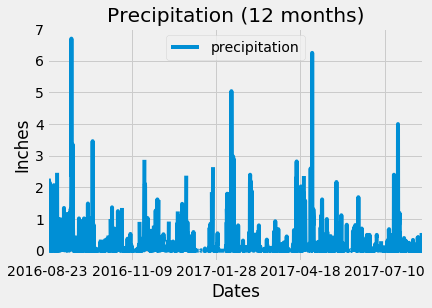

In [57]:
# Use Pandas Plotting with Matplotlib to plot the data
climate_df.plot(title="Precipitation (12 months)")
plt.legend(loc='upper center')
plt.xlabel("Dates")
plt.ylabel("Inches")
plt.savefig("Precipitation.png")
plt.show()

## Summary statistics for the precipitation data.

In [59]:
# Use Pandas to calcualte the summary statistics for the precipitation data

# Design a query to show how many stations are available in this dataset
available_stations = session.query(Measurement.station).distinct().count()
print(f"There are {available_stations} available stations")

There are 9 available stations


In [60]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.


most_active_stations = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

most_active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [62]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

# Most active station 
most_active_station = most_active_stations[0][0]
print(f"Most Active Station: {most_active_station}")


most_active_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()
print(f"Most Active Station Temperature Readings:")
print(f"Low: {most_active_temps[0][0]} High: {most_active_temps[0][1]} Average: {round(most_active_temps[0][2], 1)}")



Most Active Station: USC00519281
Most Active Station Temperature Readings:
Low: 54.0 High: 85.0 Average: 71.7


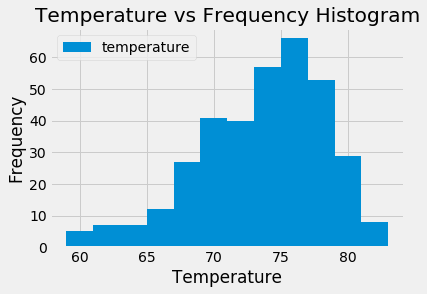

In [66]:
# Choose the station with the highest number of temperature observations.

most_temps_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
most_temps_station= most_temps_station[0]


# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_observations = session.query( Measurement.tobs).filter(Measurement.date >= date_year_ago).filter(Measurement.station == most_temps_station).all()
temp_observations = pd.DataFrame(temp_observations, columns=['temperature'])



temp_observations.plot.hist(bins=12, title="Temperature vs Frequency Histogram")
plt.tight_layout()
plt.legend(loc='upper left')
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.savefig("TempvsFreq_Histogram.png")
plt.show()


## Bonus

In [67]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [71]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

trip = calc_temps('2017-04-30','2017-05-10')
trip

[(58.0, 73.82539682539682, 80.0)]

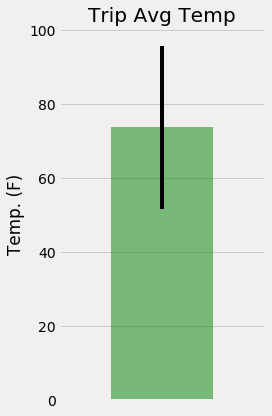

In [72]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# First create a dataframe with calculated tmin, tavg, and tmax values
trip_temp_df = pd.DataFrame(trip, columns=['tmin', 'tavg', 'tmax'])

# Then plot

trip_temp_df.plot.bar(y='tavg', yerr=(trip_temp_df['tmax'] - trip_temp_df['tmin']), title='Trip Avg Temp', color='green', alpha=0.5, figsize=(4,6))
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp. (F)")
plt.tight_layout()
plt.gca().legend_.remove()
plt.savefig("TripAvgTemp.png")
plt.show()


In [73]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

def precipitation(start_date, end_date):
    
        # Docstring for the function `calc_temps`
    """Precipitation information per weather station
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        A list of tuples containing precipitation amount, station, name, latitude, longitude, and elevation in descending order.
    """
    
    sel = [Measurement.station, 
           Station.name, 
           Station.latitude, 
           Station.longitude, 
           Station.elevation, 
           Measurement.prcp]
    
    return session.query(*sel).\
            filter(Measurement.station == Station.station).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()

print(precipitation('2017-04-30','2017-05-10'))

[('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 1.31), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.21), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 1.17), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 1.04), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.89), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.8)]
